<a href="https://colab.research.google.com/github/zaidishz/GNN_XAI_Captum/blob/main/GNN_Explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explaining GNN Model Predictions using Captum

Mutagenicity dataset from [TUDatasets](https://chrsmrrs.github.io/datasets/). This dataset consists of 4337 molecule graphs where the task is to predict the molecule mutagenicity.

In [1]:
# Install required packages.
import os
from torch import __version__, tensor
os.environ['TORCH'] = __version__
print(__version__)

%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
import numpy as  np
import itertools
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft, fftfreq
import pandas as pd

2.0.0+cpu


## Loading the dataset

load the dataset (10% of the data as the test split)

In [2]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.data import Data
import os

proxy = 'http://webproxy:8080'

os.environ['http_proxy'] = proxy
os.environ['HTTP_PROXY'] = proxy
os.environ['https_proxy'] = proxy
os.environ['HTTPS_PROXY'] = proxy

In [3]:
achse_mat = scipy.io.loadmat('C:\\Users\\vedurm01\\PycharmProjects\\ZeMA_ML\\ZeMA_Matlab\\Achse11_Szenario.mat')

trainData = achse_mat['trainData']
train_data_reshaped = []
for counter, val in enumerate(trainData):
    train_data_reshaped += [val[0]]
train_data_reshaped = np.array(train_data_reshaped)
train_data_reshaped = np.swapaxes(train_data_reshaped, 0, 1)

train_target_reshaped = achse_mat['trainTarget'].reshape(-1)

C:\Users\vedurm01\PycharmProjects\GNN_XAI_Captum\venv\lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [4]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

## Convert time-series data to torch geometric graph data. Fully connected graph with 55 edges. Each edge has the correlation between the sensors as an attribute

In [5]:
dataset = []
edge_index_perm = tensor(np.array(list(itertools.combinations(range(11), 2))).T)
triu_ind = np.triu_indices(11, k = 1)
N = 2000
Tsig = 1 / 2000.0
seconds = 5
fps = 50
for k, sample in enumerate(train_data_reshaped):
#     offset = []
#     for k in range(10):
#         for l in range(k+1,11):
#             d1 = pd.Series(sample[0][k])
#             d2 = pd.Series(sample[0][l])
#             rs = [crosscorr(d1, d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
#             offset.append(np.floor(len(rs)/2)-np.argmax(rs))
    corr_mat = np.corrcoef(sample)
#     edge_attr = np.append(np.reshape(corr_mat[triu_ind], (55,-1)), np.array(offset).reshape(55,-1), axis=1)
    edge_attr = np.reshape(corr_mat[triu_ind], (55,-1))
    corr_edge_inds = np.argwhere(np.abs(edge_attr) > np.abs(edge_attr).mean())
    edge_inds = edge_index_perm[:, corr_edge_inds[:,0]]
    scaler = StandardScaler()
    array = scaler.fit_transform(sample.T).T
    array_fft = np.abs(fft(array)[:N//2])
    dataset += [Data(edge_index=edge_inds, x=tensor(array_fft), edge_attr= tensor(edge_attr), y=tensor([train_target_reshaped[k]]))]
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]

In [6]:
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

## Visualizing the data


In [7]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx


def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = 'Sensor '+str(u+1)
    return g


In [8]:
import random

data = random.choice([t for t in train_dataset])
print(data)
g = to_molecule(data)

Data(x=[11, 2000], edge_index=[2, 16], edge_attr=[55, 1], y=[1])


In [9]:
g = to_networkx(data, node_attrs=['x'], to_undirected=True, remove_self_loops=True)
print(data.num_edges)
print(g.nodes(data=True))

16
[(0, {'x': [2.842170943040401e-14, 38.573548575162455, 44.44269616874044, 26.86198588899462, 31.46884060467994, 34.242366896729756, 32.893122547484595, 20.002637491425563, 9.409203270201612, 4.65887056953393, 5.992828541869854, 1.206077122891635, 5.152344557347617, 0.9561414463054595, 3.8626453415290736, 9.721666621244104, 2.093022395445348, 4.972982716847885, 7.604327074945555, 16.892692572194772, 7.74870503200512, 18.443481131955313, 12.506532927020066, 20.896691187468267, 32.92434961556677, 23.873104514486016, 8.821724450186954, 13.507420284384805, 12.00126780331553, 12.58697175750975, 10.011945329851214, 21.056343877239858, 49.624567516684955, 116.28703484250913, 24.5345991385926, 10.401294709594003, 11.005653334873513, 13.650025333465123, 9.534905840796776, 10.243960049530797, 36.76227131372416, 1.4857122834553993, 17.557648846620086, 6.795871225467941, 24.073541935687768, 11.181223101966788, 17.557710034642195, 22.933693656607808, 237.81626360428172, 9.14801168467832, 20.14730

## Sample visualization

We sample a single molecule from train_dataset and visualize it

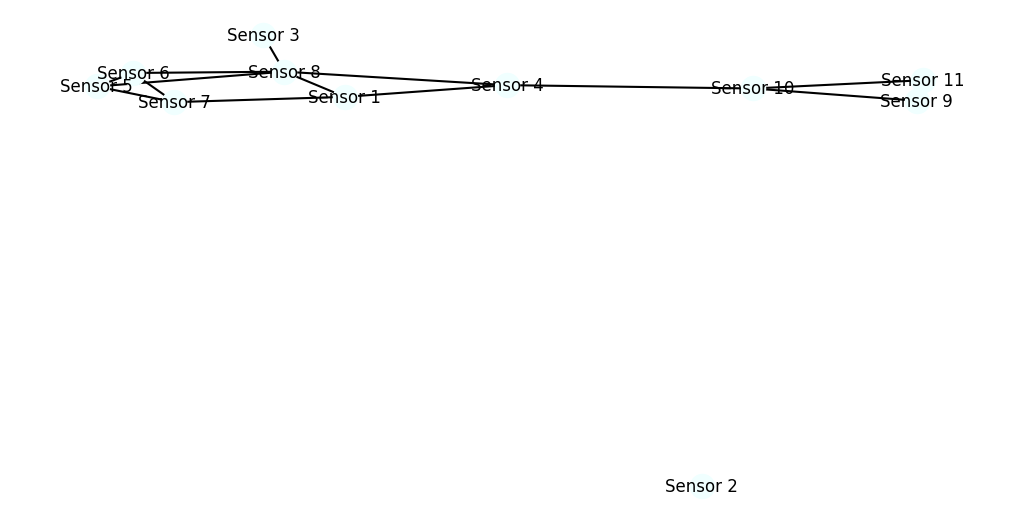

In [10]:
import random

data = random.choice([t for t in train_dataset])
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

In [ ]:
T=1/2000.0
N=2000
y = fft(train_data_reshaped[0][0])
xf = fftfreq(N, T)[:N//2]

In [ ]:
plt.plot(xf, 2.0/N * np.real(y[0:N//2]))
plt.plot(xf, 2.0/N * np.imag(y[0:N//2]))

In [ ]:
plt.plot(xf, 2.0/N * np.abs(y[0:N//2]))

In [ ]:
plt.plot(train_data_reshaped[500][7])

In [ ]:
plt.scatter(train_data_reshaped[0][5], train_data_reshaped[0][6])

In [ ]:
np.abs(y[0:N//2]).max() / np.abs(y[0:N//2]).min()

In [ ]:
alldat=[]
for k in range(11):
    T=1/2000.0
    N=2000
    y = fft(train_data_reshaped[0][k])
#     plt.scatter((k+1)*np.ones(1000), 2.0/N * np.abs(y[0:N//2]))
    alldat.append(np.abs(y))

In [ ]:
plt.boxplot(alldat)

In [ ]:
df_temp=pd.DataFrame(train_data_reshaped[0].T, columns=['Sensor '+str(k+1) for k in range(11)])
d1 = df_temp['Sensor 5']
d2 = df_temp['Sensor 6']

In [ ]:
triu_ind = np.triu_indices(11, k = 1)
corr_mat = np.corrcoef(train_data_reshaped[0])
corr_arr=np.reshape(corr_mat[triu_ind], (55,-1))

In [ ]:
np.append(corr_arr, np.linspace(1,55,55).reshape(55,-1), axis=1)

In [ ]:
tensor(np.array(list(itertools.permutations(range(1,12), 2))).T)

In [ ]:
triu_ind

In [ ]:
corr_edge_inds = np.argwhere(np.abs(edge_attr) > np.abs(edge_attr).mean())

edge_index_perm[:, corr_edge_inds[:,0]]

In [ ]:
corr_edge_inds[:,0]